In [1]:
#Final Code. This is the main version of NCBXI_api

import os
import torch
import pickle
import numpy as np
from PIL import Image
from matplotlib.image import imread
from torchvision import transforms
import matplotlib.pyplot as plt
from NeuralConceptBinder.neural_concept_binder import NeuralConceptBinder


class Args:
    def __init__(self,model_path):
        # Generic Parameters
        self.name = "test_run"
        self.mode = "test"
        self.resume = None
        self.seed = 10
        self.epochs = 10
        self.lr = 1e-2
        self.l2_grads = 1.0
        self.batch_size = 32
        self.num_workers = 4
        self.no_cuda = False
        self.train_only = False
        self.eval_only = True
        self.multi_gpu = False
        self.data_dir = "../data/CLEVR-4-1/"
        self.model_path = model_path
        self.fp_ckpt = f"{self.model_path}best_model.pt"
        self.fp_pretrained_ckpt = None
        self.precompute_bind = False

        # SysBinder Arguments
        self.image_size = 128
        self.image_channels = 3
        self.lr_dvae = 3e-4
        self.lr_enc = 1e-4
        self.lr_dec = 3e-4
        self.lr_warmup_steps = 30000
        self.lr_half_life = 250000
        self.clip = 0.05
        self.num_iterations = 3
        self.num_slots = 1
        self.num_blocks = 16
        self.cnn_hidden_size = 512
        self.slot_size = 2048
        self.mlp_hidden_size = 192
        self.num_prototypes = 64
        self.temp = 1.0
        self.temp_step = False
        self.vocab_size = 4096
        self.num_decoder_layers = 8
        self.num_decoder_heads = 4
        self.d_model = 192
        self.dropout = 0.1
        self.tau_start = 1.0
        self.tau_final = 0.1
        self.tau_steps = 30000
        self.binarize = False
        self.attention_codes = False

        # Retrieval & Binding Arguments
        self.checkpoint_path = f"{self.model_path}best_model.pt"
        self.retrieval_corpus_path = f"{self.model_path}block_concept_dicts.pkl"
        self.retrieval_encs = "proto-exem"
        self.majority_vote = False
        self.topk = 5
        self.thresh_attn_obj_slots = 0.98
        self.thresh_count_obj_slots = -1
        self.deletion_dict_path = None
        self.merge_dict_path = None
        self.feedback_path = None
        self.expl_thresh = 0.5
        self.lambda_expl = 100
        self.set_transf_hidden = 256
        self.device = "cuda" if torch.cuda.is_available() else "cpu"


# Function to load the pretrained model
def load_model(args):
    model = NeuralConceptBinder(args)
    checkpoint = torch.load(args.checkpoint_path, map_location=args.device)
    #print(f"Checkpoint num_blocks: {checkpoint['args'].num_blocks}")  # If checkpoint stores the training args
    model.load_state_dict(checkpoint['model'], strict=False)
    model.to(args.device)
    model.eval()
    #print(f"Model num_blocks: {model.num_blocks}")

    return model


# Preprocess the input image for the model
def preprocess_image(image_path, img_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image





# Run inference for the input image
def run_inference(image_tensor, model, device):
    image_tensor = image_tensor.to(device)
    model.eval()
    with torch.no_grad():
        codes, probs = model.encode(image_tensor)
    return codes, probs


# Preprocess image paths for implicit inspection
def preprocess_image_paths(all_img_locs):
    for i in range(len(all_img_locs)):
        if "wolf" in all_img_locs[i]:
            all_img_locs[i] = "data/" + "/".join(all_img_locs[i].split("/")[3:])
    return all_img_locs


#  Load the retrieval corpus and create block concepts.
def create_block_concepts(retrieval_corpus_path):
    print("Loading retrieval corpus...")
    with open(retrieval_corpus_path, "rb") as f:
        retrieval_corpus = pickle.load(f)

    block_concepts = {}
    for block_idx, block in enumerate(retrieval_corpus):
        if 'exemplars' in block:
            block_concepts[block_idx] = {
                'exemplars': block['exemplars'],
                'prototypes': block['prototypes']
            }
        else:
            print(f"Block {block_idx} has no exemplars.")

    print(f"Loaded block concepts: {list(block_concepts.keys())}")
    return block_concepts

# Convert a tensor image to a NumPy array for visualization.  'tensor_img' is the Tensor representation of the image.
def tensor_img_to_np(tensor_img: torch.Tensor):
    tensor_img = tensor_img.detach().cpu()
    if len(tensor_img.shape) == 4:  # Batch of images
        img = tensor_img.permute(0, 2, 3, 1).numpy()
    else:  # Single image
        img = tensor_img.permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)  # Ensure pixel values are in range




# Function: slots_to_blocks
def slots_to_blocks(slots, args):
    B, num_slots, slot_size = slots.shape
    block_size = slot_size // args.num_blocks
    assert slot_size % args.num_blocks == 0, "slot_size must be divisible by num_blocks"
    return slots.view(B, args.num_blocks, block_size)


# Load an image as a tensor specifically for conceptual inspection. Returns Torch tensor of the image suitable for encoding.
def load_img_as_tensor(file_path: str, device: str):   
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    img = Image.open(file_path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)




# To visualize the blocks and their activated concepts.
def visualize_block(block_idx, codes,model_path):
    codes = codes.squeeze(0).cpu().numpy()
    base_path = f"{model_path}clustered_exemplars/"
    output_plot_path = "static/images/plots/Visualize_Concept_Block/Concept_Block.png"

    concept_id = int(codes[0, block_idx])
    concept_image_path = os.path.join(base_path, f"block{block_idx}_{concept_id}.png")

    plt.figure(figsize=(8, 8))
    if os.path.exists(concept_image_path):
        concept_image = imread(concept_image_path)
        plt.imshow(concept_image)
        plt.title(f"Block {block_idx}, Concept {concept_id}", fontsize=14)
    else:
        plt.text(
            0.5, 0.5, "Image Not Found", fontsize=12, ha='center', va='center'
        )
        plt.title(f"Block {block_idx}, Concept {concept_id} (Image Not Found)", fontsize=14)
    plt.axis("off")
    plt.tight_layout()

    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_plot_path ), exist_ok=True)

    # Delete the previous image if it exists
    if os.path.exists(output_plot_path):
        os.remove(output_plot_path )

    # Save the new plot
    plt.savefig(output_plot_path , bbox_inches="tight", dpi=300)
    plt.show()
    print(f'Plot of Visual Concept Block has been saved to "{output_plot_path}"')




# Function for the Implicit Inspection. Direct inspection of the exemplars of a cluster. Generates a plot with exp_per_cluster exemplars of the specified cluster from the specified block
def implicit_inspection(block_concepts, all_img_locs, block_id: int, cluster_id: int, exp_per_cluster: int = 5, title: str = None):

    # To raise error when block_id or cluster_id out of range
#    if block_id not in block_concepts:
#        raise ValueError(f"Block ID {block_id} is out of range. Available blocks: {list(block_concepts.keys())}.")
#    
#    if cluster_id >= len(block_concepts[block_id]['prototypes']['ids']):
#        raise ValueError(f"Cluster ID {cluster_id} is out of range for Block {block_id}. "
#                         f"Available clusters: {len(block_concepts[block_id]['prototypes']['ids']) - 1}.")
    
        
    # To print error instead of raise error when block_id or cluster_id out of range
    if block_id not in block_concepts:
        print(f"Block ID {block_id} is out of range. Available blocks: {list(block_concepts.keys())}.")
        return
    
    if cluster_id >= len(block_concepts[block_id]['prototypes']['ids']):
        print(f"Cluster ID {cluster_id} is out of range for Block {block_id}. "
              f"Available clusters: {len(block_concepts[block_id]['prototypes']['ids']) - 1}.")
        return
   

    #assert block_id in block_concepts, f"Block {block_id} not found in block_concepts."
    #assert cluster_id < len(block_concepts[block_id]['prototypes']['ids']), "Cluster id exceeds number of clusters."

    output_plot_path = "static/images/plots/Implicit_Inspection/Implicit_Inspection.png"

    exemplar_ids = block_concepts[block_id]['exemplars']['exemplar_ids'][cluster_id]
    num_exemplars = len(exemplar_ids)
    if num_exemplars < exp_per_cluster:
        print(f"Cluster {cluster_id} in Block {block_id} has only {num_exemplars} exemplars. Adjusting to available size.")
        exp_per_cluster = num_exemplars

    fig, axs = plt.subplots(1, exp_per_cluster, figsize=(15, 5))

    for i in range(exp_per_cluster):
        exemplar_id = exemplar_ids[i]
        image_path = all_img_locs[exemplar_id]
        axs[i].imshow(imread(image_path))
        axs[i].axis('off')
        axs[i].set_title(f"Exemplar {i+1}")

    if title:
        plt.suptitle(title, fontsize=16)
        plt.savefig(f"plots/{title}.pdf")
    else:
        plt.suptitle(f"Implicit Inspection: Block {block_id}, Cluster {cluster_id}", fontsize=16)
        plt.tight_layout()

        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_plot_path ), exist_ok=True)

        # Delete the previous image if it exists
        if os.path.exists(output_plot_path):
            os.remove(output_plot_path )

        # Save the new plot
        plt.savefig(output_plot_path , bbox_inches="tight", dpi=300)

        plt.show()
        print(f'Plot of Implicit Inspection has been saved to "{output_plot_path}"')





# Function for the Comparative Inspection. Perform comparative inspection by comparing a given example's activation in the context of a specified block and cluster
def comparative_inspection(block_concepts, all_img_locs, example_path: str, block_id: int,  max_exemplars: int = 10):

    # To raise error when block_id or cluster_id out of range
#    if block_id not in block_concepts:
#        raise ValueError(f"Block ID {block_id} is out of range. Available blocks: {list(block_concepts.keys())}.")
    
#    if cluster_id >= len(block_concepts[block_id]['prototypes']['ids']):
#        raise ValueError(f"Cluster ID {cluster_id} is out of range for Block {block_id}. "
#                         f"Available clusters: {len(block_concepts[block_id]['prototypes']['ids']) - 1}.")
 

    # To print error instead of raise error when block_id or cluster_id out of range
    if block_id not in block_concepts:
        print(f"Block ID {block_id} is out of range. Available blocks: {list(block_concepts.keys())}.")
        return
    
    #assert block_id in block_concepts, f"Block {block_id} not found in block_concepts."

    output_plot_path = "static/images/plots/Comparative_Inspection/Comparative_Inspection.png"

    cluster_data = block_concepts[block_id]['prototypes']
    prototypes = cluster_data['prototypes']
    
    # Load the example image
    example_tensor = load_img_as_tensor(example_path,device="cpu")
    
    # Compute the distance between the example and each prototype
    distances = [torch.norm(example_tensor - torch.tensor(proto)) for proto in prototypes]

    # Find the closest prototype in the cluster
    closest_cluster_idx = np.argmin(distances)
    print(f"Closest cluster for Block {block_id} is Cluster {closest_cluster_idx}.")

    # Get exemplars for the closest cluster
    exemplar_ids = block_concepts[block_id]['exemplars']['exemplar_ids'][closest_cluster_idx]
    exemplar_ids = exemplar_ids[:max_exemplars]  # Limit to `max_exemplars`

    # Set up the figure
    fig, axs = plt.subplots(1, len(exemplar_ids) + 1, figsize=(4 * (len(exemplar_ids) + 1), 4))

    # Display the example image
    axs[0].imshow(imread(example_path))
    axs[0].axis("off")
    axs[0].set_title("Example Image")

    # Display the exemplars for the closest cluster
    for i, exemplar_id in enumerate(exemplar_ids):
        image_path = all_img_locs[exemplar_id]
        axs[i + 1].imshow(imread(image_path))
        axs[i + 1].axis("off")
        axs[i + 1].set_title(f"Exemplar {i+1}")

    plt.suptitle(f"Comparative Inspection: Block {block_id}, Cluster {closest_cluster_idx}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)  # Adjust spacing

    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_plot_path ), exist_ok=True)

    # Delete the previous image if it exists
    if os.path.exists(output_plot_path):
        os.remove(output_plot_path )

    # Save the new plot
    plt.savefig(output_plot_path , bbox_inches="tight", dpi=300)
    plt.show()
    print(f'Plot of Comparative Inspection has been saved to "{output_plot_path}"')





# Function for the Conceptual Inspection. Perform conceptual inspection by modifying the encoding of an image  with a prototype tensor from the specified block and cluster.
def conceptual_inspection(block_concepts, model, example_path: str, block_id: int, cluster_id: int, args):

    # To raise error when block_id or cluster_id out of range
#    if block_id not in block_concepts:
#        raise ValueError(f"Block ID {block_id} is out of range. Available blocks: {list(block_concepts.keys())}.")
    
#    if cluster_id >= len(block_concepts[block_id]['prototypes']['ids']):
#        raise ValueError(f"Cluster ID {cluster_id} is out of range for Block {block_id}. "
#                         f"Available clusters: {len(block_concepts[block_id]['prototypes']['ids']) - 1}.")
    

    # To print error instead of raise error when block_id or cluster_id out of range
    if block_id not in block_concepts:
        print(f"Block ID {block_id} is out of range. Available blocks: {list(block_concepts.keys())}.")
        return
    
    if cluster_id >= len(block_concepts[block_id]['prototypes']['ids']):
        print(f"Cluster ID {cluster_id} is out of range for Block {block_id}. "
              f"Available clusters: {len(block_concepts[block_id]['prototypes']['ids']) - 1}.")
        return
    

    output_plot_path = "static/images/plots/Conceptual_Inspection/Conceptual_Inspection.png"


    # Validate cluster_id
    #assert cluster_id < len(block_concepts[block_id]['prototypes']['ids']), f"Cluster id {cluster_id} exceeds the number of clusters."

    # Load the image as a tensor
    img_tensor = load_img_as_tensor(example_path, model.device)

    # Encode the image
    enc = model.model.encode(img_tensor)[0]

    # Convert slots to blocks
    enc = slots_to_blocks(enc, args)
    #print(f"Encoding shape after reshaping to blocks: {enc.shape}")

    # Verify block_id is valid
    num_blocks = enc.size(2)  # Number of blocks in the tensor
    #print(f"Available blocks: {num_blocks}")
    assert block_id < num_blocks, f"Block ID {block_id} is out of bounds. Available blocks: {num_blocks - 1}"

    # Retrieve the prototype encoding
    proto_enc = torch.tensor(
        block_concepts[block_id]['prototypes']['prototypes'][cluster_id],
        device=enc.device
    ).unsqueeze(0)  # Ensure correct dimensions

    # Resize prototype if necessary
    if proto_enc.shape[-1] != enc.shape[-1]:
        print(f"Resizing prototype from {proto_enc.shape[-1]} to {enc.shape[-1]}")
        proto_enc = torch.nn.functional.pad(proto_enc, (0, enc.shape[-1] - proto_enc.shape[-1]))

    # Validate prototype dimensions
    assert proto_enc.shape[-1] == enc.shape[-1], (
        f"Prototype tensor size mismatch: expected {enc.shape[-1]}, got {proto_enc.shape[-1]}"
    )

    # Swap the block encoding with the prototype
    swapped_enc = enc.clone()
    swapped_enc[:, block_id, :] = proto_enc

    # Reshape back to original slot dimensions for decoding
    swapped_slots = swapped_enc.view(enc.size(0), -1, args.slot_size)

    # Decode the swapped encoding
    swapped_img = tensor_img_to_np(model.model.decode(swapped_slots))[0]

    # Display the swapped image with the specified title
    plt.figure(figsize=(4, 4))
    plt.imshow(swapped_img)
    plt.axis('off')
    plt.title(f"Conceptual Inspection: Block {block_id}, Cluster {cluster_id}", fontsize=12)
    plt.tight_layout()

    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_plot_path ), exist_ok=True)

    # Delete the previous image if it exists
    if os.path.exists(output_plot_path):
        os.remove(output_plot_path )

    # Save the new plot
    plt.savefig(output_plot_path , bbox_inches="tight", dpi=300)
    plt.show()
    print(f'Plot of Conceptual Inspection has been saved to "{output_plot_path}"')


Loading retrieval corpus from ../model/CLEVR-4/retbind_seed_2/block_concept_dicts.pkl ...

Number of concepts per block: 
[244, 4, 10, 5, 63, 28, 1, 5, 4, 3, 5, 1, 4, 16, 21, 6]



e:\ARMAN\STUDY\ICE\SEMESTER SUBJECTS\Winter 24\AI LAB\Our Work\Code Part\Main Code to Run Model\Explainability Interface for Neural Concept Binder\.venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loaded ...../model/CLEVR-4/retbind_seed_2/best_model.pt
Device on :  cuda
Shape of the output: torch.Size([1, 1, 16])
Activated Concepts for Each Block: tensor([[[167.,   0.,   3.,   2.,  55.,  21.,   0.,   0.,   2.,   0.,   2.,
            0.,   0.,   0.,   5.,   1.]]])


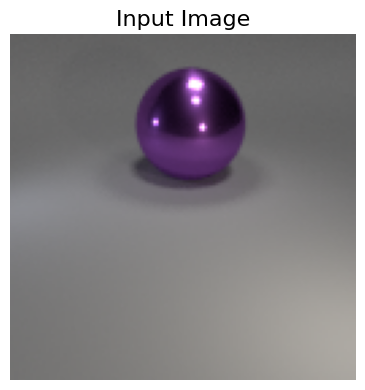

Showing Activated Concepts for a Block


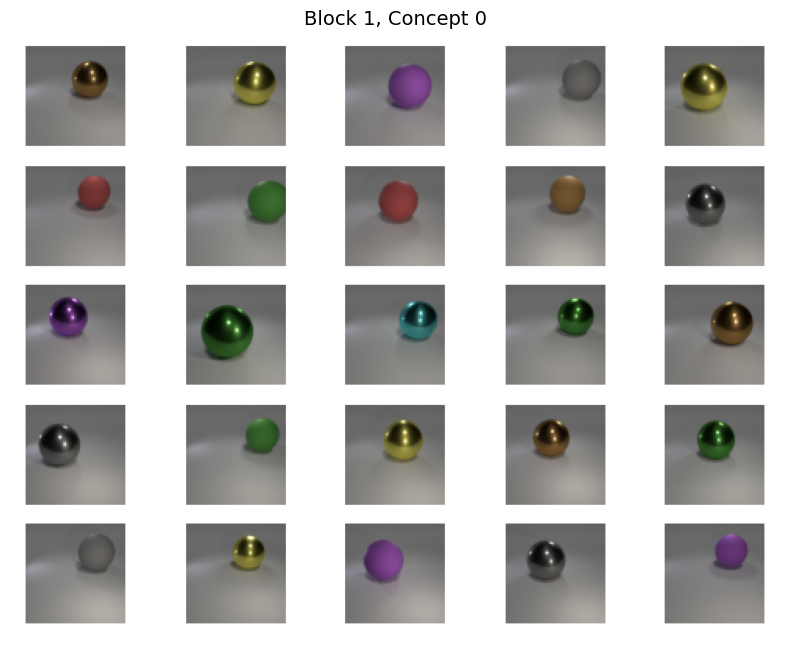

Plot of Visual Concept Block has been saved to "static/images/plots/Visualize_Concept_Block/Concept_Block.png"


In [2]:
model_path="../model/CLEVR-4/retbind_seed_2/"

args = Args(model_path=model_path)
torch.manual_seed(args.seed)


device = args.device

# Load the model
model = load_model(args)

# Image preprocessing
image_path = "../data/CLEVR-4-1/test/images/CLEVR_4_classid_0_000008.png" # Path of the sample image
image_tensor, input_image = preprocess_image(image_path, args.image_size)

# Inference
codes, probs = run_inference(image_tensor, model, device)

print("Device on : ", args.device)
print("Shape of the output:", codes.shape)
print("Activated Concepts for Each Block:", codes)

# Display the input image
plt.figure(figsize=(4, 4))
plt.imshow(input_image)
plt.title("Input Image", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


# To visualize Activated Block. For example Block 1 is used here
print("Showing Activated Concepts for a Block")
block_idx = 1
visualize_block(block_idx, codes,model_path)

Loading retrieval corpus...
Loaded block concepts: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Showing Implicit Inspection


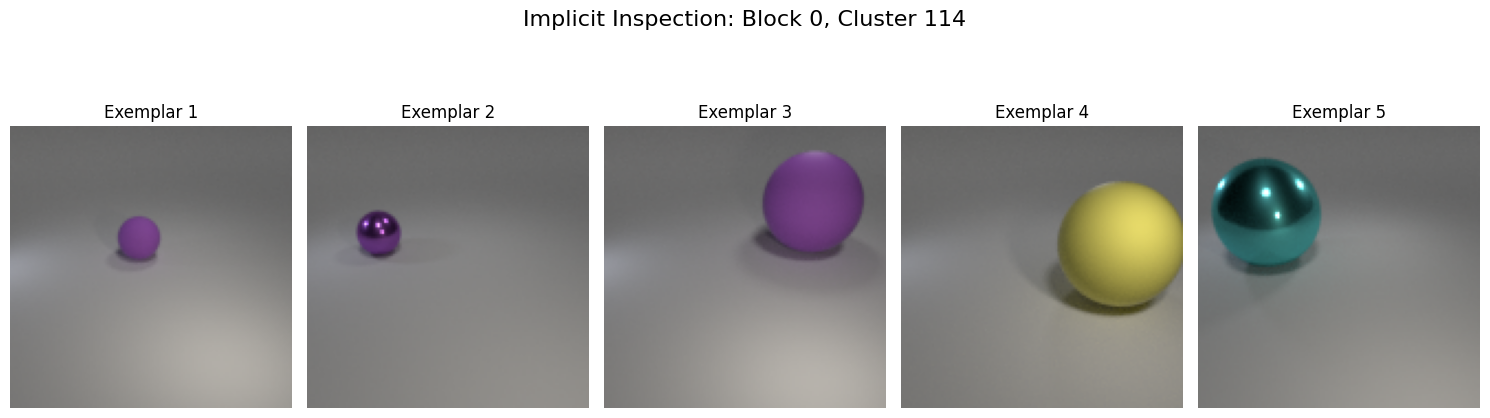

Plot of Implicit Inspection has been saved to "static/images/plots/Implicit_Inspection/Implicit_Inspection.png"


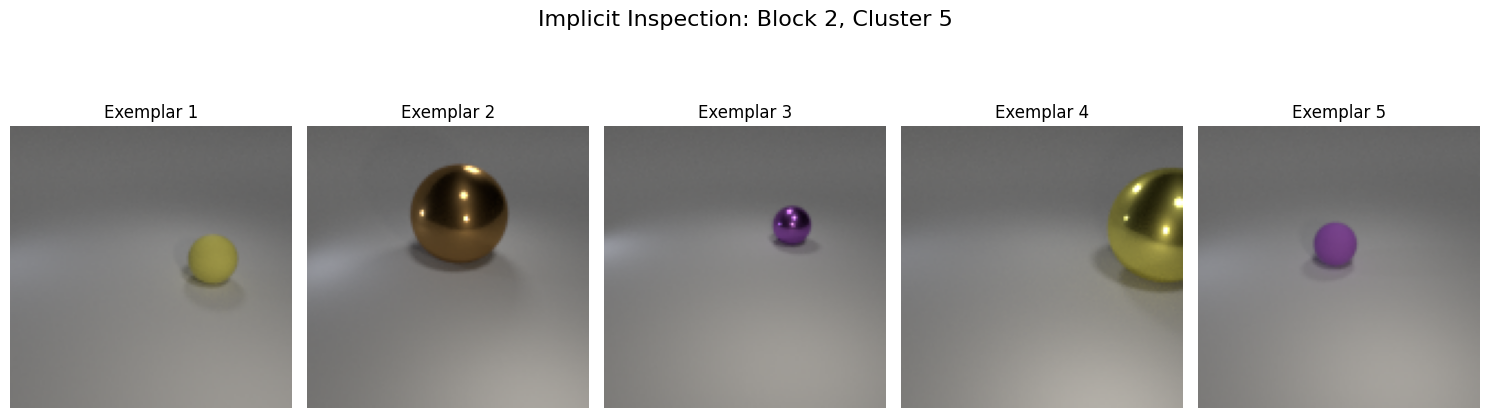

Plot of Implicit Inspection has been saved to "static/images/plots/Implicit_Inspection/Implicit_Inspection.png"


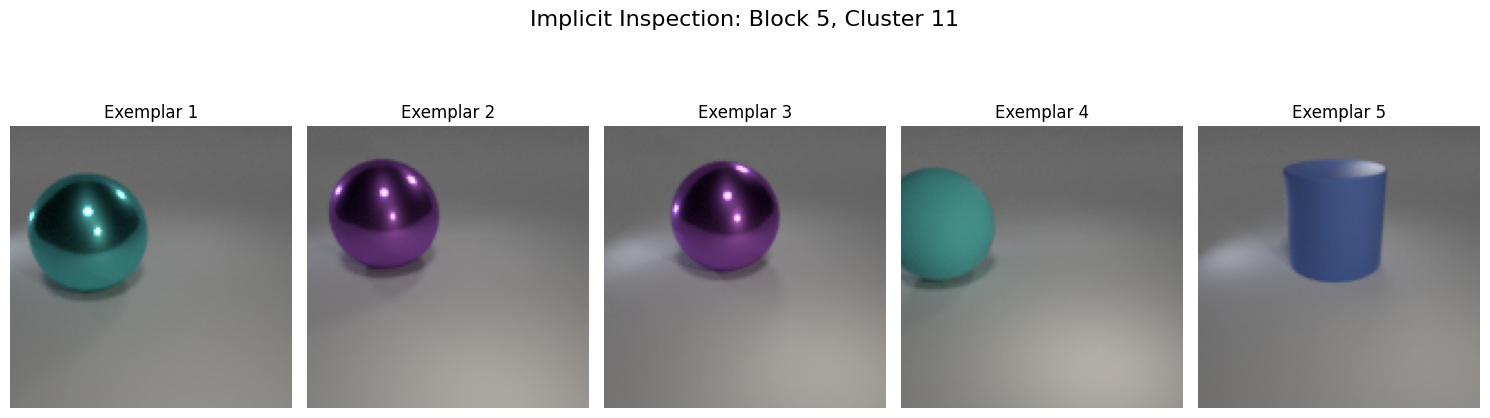

Plot of Implicit Inspection has been saved to "static/images/plots/Implicit_Inspection/Implicit_Inspection.png"
Block ID 16 is out of range. Available blocks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].
Cluster ID 5 is out of range for Block 9. Available clusters: 2.


In [3]:
# Example: Perform implicit inspection
    
# Create block concepts
block_concepts = create_block_concepts(args.retrieval_corpus_path)
    
# Preprocess image paths
all_img_locs = [args.data_dir+f"train/images/CLEVR_4_classid_0_{i:06}.png" for i in range(5000)]
all_img_locs = preprocess_image_paths(all_img_locs)

# Calling Implicit Inspection

print("Showing Implicit Inspection")
implicit_inspection(block_concepts, all_img_locs, block_id=0, cluster_id=114)
implicit_inspection(block_concepts, all_img_locs, block_id=2, cluster_id=5)
implicit_inspection(block_concepts, all_img_locs, block_id=5, cluster_id=11)
    
implicit_inspection(block_concepts, all_img_locs, block_id=16, cluster_id=5) #To check block_id  out of range
implicit_inspection(block_concepts, all_img_locs, block_id=9, cluster_id=5) #To check  cluster_id out of range



Showing Comparative Inspection
Closest cluster for Block 6 is Cluster 0.


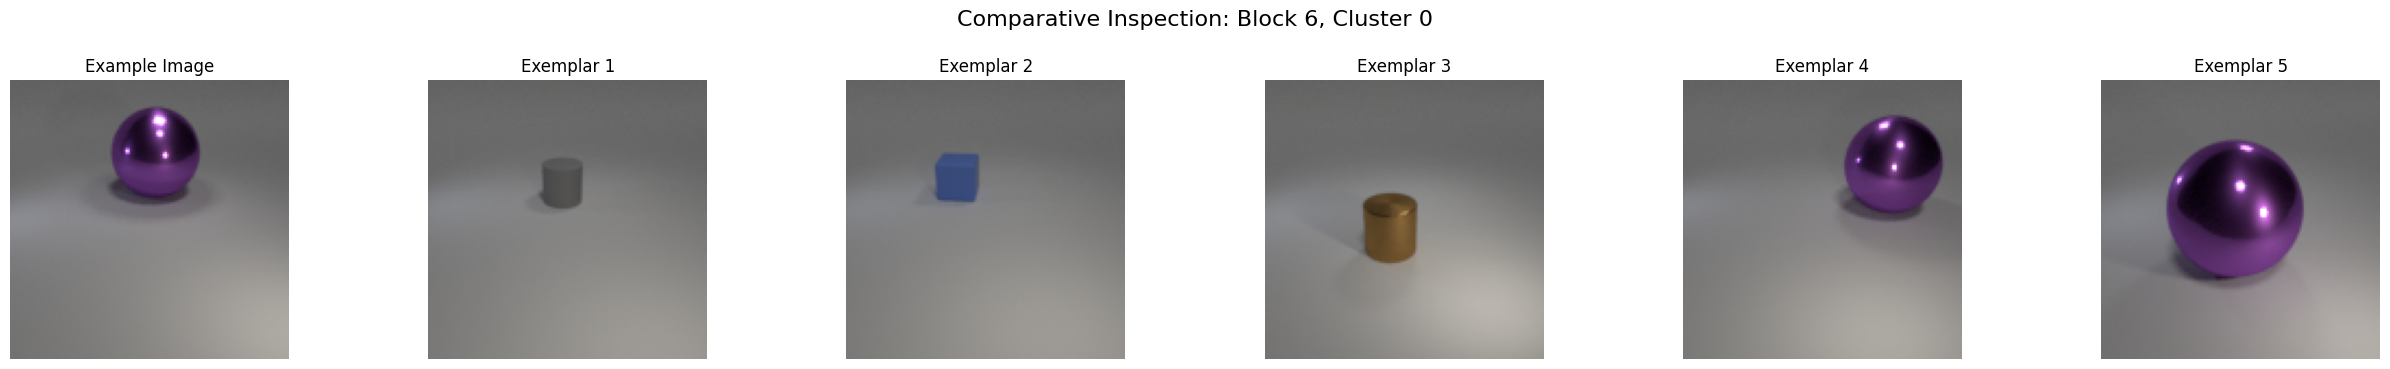

Plot of Comparative Inspection has been saved to "static/images/plots/Comparative_Inspection/Comparative_Inspection.png"
Closest cluster for Block 8 is Cluster 3.


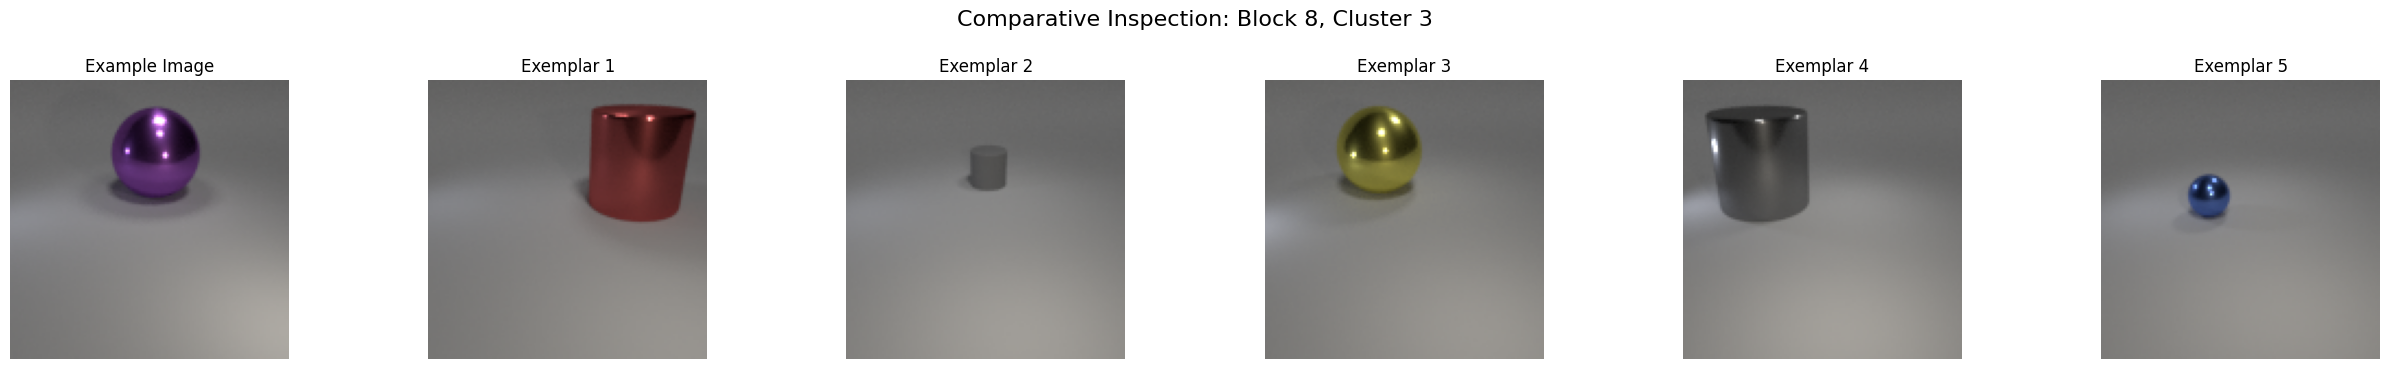

Plot of Comparative Inspection has been saved to "static/images/plots/Comparative_Inspection/Comparative_Inspection.png"
Closest cluster for Block 13 is Cluster 2.


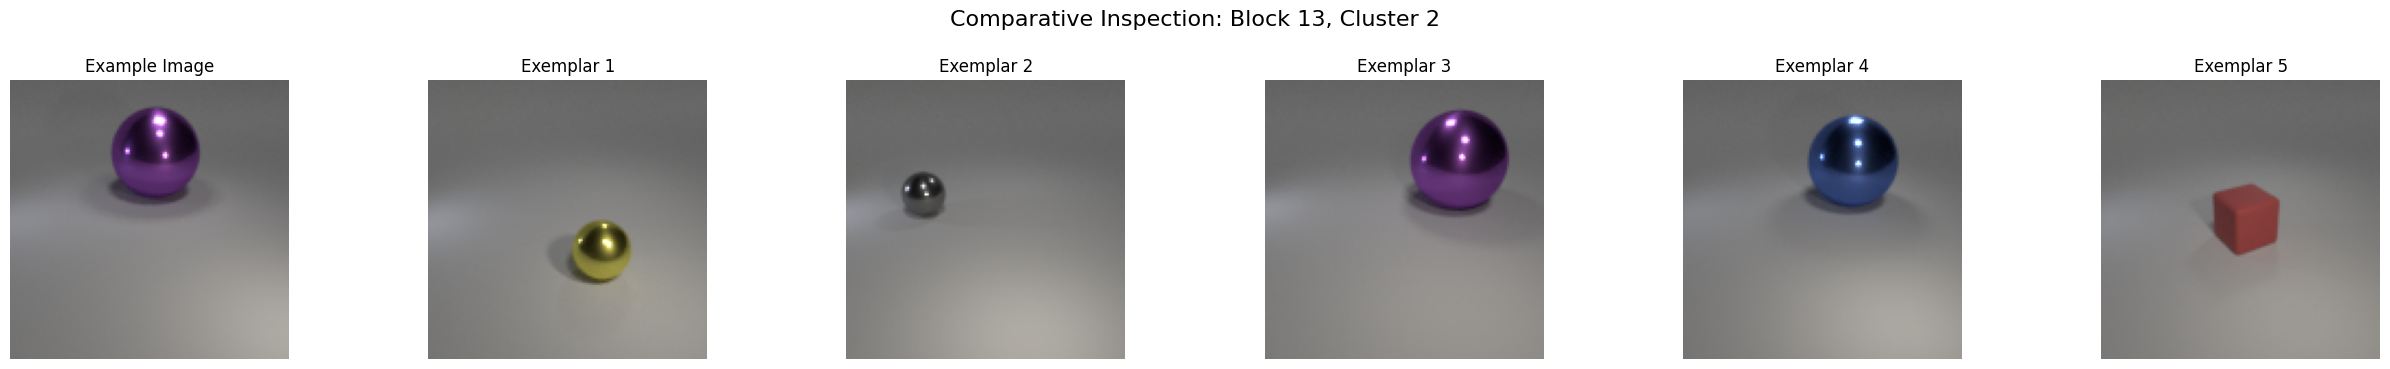

Plot of Comparative Inspection has been saved to "static/images/plots/Comparative_Inspection/Comparative_Inspection.png"
Block ID 16 is out of range. Available blocks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].


In [4]:
# Example: Perform comparative inspection
# Calling comparative inspection
print("Showing Comparative Inspection")
    
comparative_inspection(block_concepts, all_img_locs, example_path=image_path,block_id=6,max_exemplars=5)
comparative_inspection(block_concepts, all_img_locs, example_path=image_path,block_id=8,max_exemplars=5)
comparative_inspection(block_concepts, all_img_locs, example_path=image_path,block_id=13,max_exemplars=5)
    
comparative_inspection(block_concepts, all_img_locs, example_path=image_path,block_id=16,max_exemplars=5) #To check block_id  out of range


Showing  Conceptual Inspection
Block ID 16 is out of range. Available blocks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].
Cluster ID 5 is out of range for Block 9. Available clusters: 2.


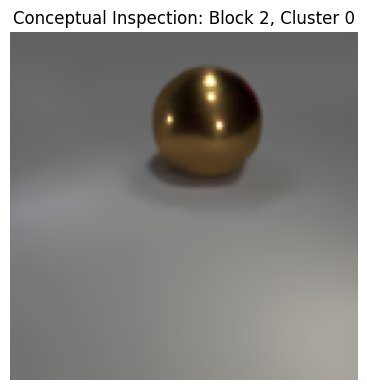

Plot of Conceptual Inspection has been saved to "static/images/plots/Conceptual_Inspection/Conceptual_Inspection.png"


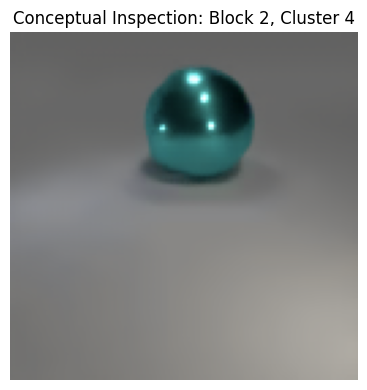

Plot of Conceptual Inspection has been saved to "static/images/plots/Conceptual_Inspection/Conceptual_Inspection.png"


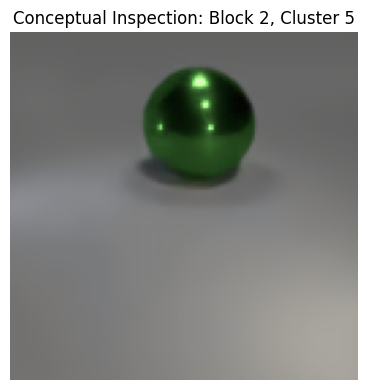

Plot of Conceptual Inspection has been saved to "static/images/plots/Conceptual_Inspection/Conceptual_Inspection.png"


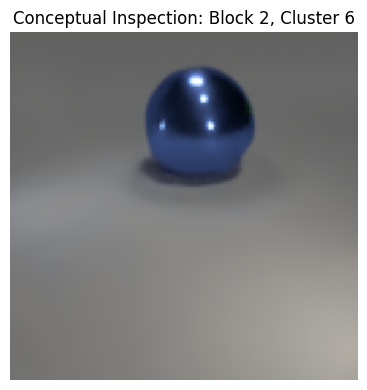

Plot of Conceptual Inspection has been saved to "static/images/plots/Conceptual_Inspection/Conceptual_Inspection.png"


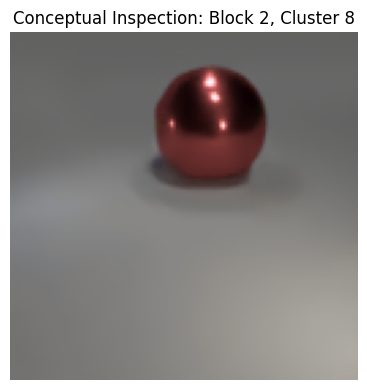

Plot of Conceptual Inspection has been saved to "static/images/plots/Conceptual_Inspection/Conceptual_Inspection.png"


In [5]:
# Example: Perform Conceptual Inspection
# Calling Conceptual Inspection
print("Showing  Conceptual Inspection")
conceptual_inspection(block_concepts, model, example_path=image_path, block_id=16, cluster_id=5, args=args) #To check block_id  out of range
conceptual_inspection(block_concepts, model, example_path=image_path, block_id=9, cluster_id=5, args=args) #To check cluster_id out of range




conceptual_inspection(block_concepts, model, example_path=image_path, block_id=2, cluster_id=0, args=args)

conceptual_inspection(block_concepts, model, example_path=image_path, block_id=2, cluster_id=4, args=args)
conceptual_inspection(block_concepts, model, example_path=image_path, block_id=2, cluster_id=5, args=args)
conceptual_inspection(block_concepts, model, example_path=image_path, block_id=2, cluster_id=6, args=args)

conceptual_inspection(block_concepts, model, example_path=image_path, block_id=2, cluster_id=8, args=args)